In [40]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

In [41]:
gamesurl = "https://www.mobygames.com/platform/switch/"
r = requests.get(gamesurl)
print(r.status_code)
gamesbs = BeautifulSoup(r.text)

200


In [27]:
title1 = gamesbs.find('td', {'class': 'text-nowrap'}).find('a').text
link1 = gamesbs.find('td', {'class': 'text-nowrap'}).find('a')['href']
year1 = gamesbs.find('td', {'class': 'text-center text-nowrap'}).text
#genre1 = gamesbs.find('td', {'class': 'overflow-x-scroll'}).find('a').text
score1 = gamesbs.find('div', {'class': 'mobyscore'}).text

#perspective
#gameplay
#setting
#ESRB


print(title1,link1, year1, score1)

Super Mario Odyssey https://www.mobygames.com/game/96127/super-mario-odyssey/ 
      2017
     
    9.4
  


In [68]:
import pandas as pd
import requests
import time
from io import StringIO

titles = []
links = []
years = []
scores = []
genres = []

base_url = gamesurl 
max_pages = 10

for page_count in range(0, max_pages + 1):
    # Construct URL for each page
    if page_count == 0:
        page_url = base_url  # First page has no /page:x/
    else:
        page_url = f"{base_url}page:{page_count}/"

    print(f"Requesting URL: {page_url}")

    response = requests.get(page_url)
    tables = pd.read_html(StringIO(response.text))  # Get all tables on the page

    # Assuming the table you want is the first one (tables[0])
    games_df = tables[0]  

    # Extract relevant columns from games_df as needed
    titles.extend(games_df['Title'].tolist())  # replace 'Title' with the actual column name
    years.extend(games_df['Released'].tolist())  # replace 'Year' with the actual column name
    scores.extend(games_df['Moby Score'].tolist())  # replace 'Score' with the actual column name
    genres.extend(games_df['Genres'].tolist())

    # If links are in another structure on the page, BeautifulSoup might still be useful:
    gamesbs = BeautifulSoup(response.text, 'html.parser')
    game_links = [tag['href'] for tag in gamesbs.select('td.text-nowrap a')]
    links.extend(game_links)

    page_count += 1
    time.sleep(3)  # Respectful delay for scraping

print(f"Collected {len(titles)} titles.")


Requesting URL: https://www.mobygames.com/platform/switch/
Requesting URL: https://www.mobygames.com/platform/switch/page:1/
Requesting URL: https://www.mobygames.com/platform/switch/page:2/
Requesting URL: https://www.mobygames.com/platform/switch/page:3/
Requesting URL: https://www.mobygames.com/platform/switch/page:4/
Requesting URL: https://www.mobygames.com/platform/switch/page:5/
Requesting URL: https://www.mobygames.com/platform/switch/page:6/
Requesting URL: https://www.mobygames.com/platform/switch/page:7/
Requesting URL: https://www.mobygames.com/platform/switch/page:8/
Requesting URL: https://www.mobygames.com/platform/switch/page:9/
Requesting URL: https://www.mobygames.com/platform/switch/page:10/
Collected 550 titles.


In [173]:
basic_games = {
    'Title': titles,
    'Score': scores,
    'Year': years,
    'Genre': genres
}

basic_games_df = pd.DataFrame(basic_games)

# Print the DataFrame
print(basic_games_df)

                                            Title  Score  Year  \
0                             Super Mario Odyssey    9.4  2017   
1         The Legend of Zelda: Breath of the Wild    9.4  2017   
2       The Legend of Zelda: Tears of the Kingdom    9.3  2023   
3                       Metroid Prime: Remastered    9.3  2023   
4                                   Hollow Knight    9.1  2018   
..                                            ...    ...   ...   
545  Ace Combat 7: Skies Unknown (Deluxe Edition)    7.8  2024   
546                        The Darkside Detective    7.8  2018   
547                            Night in the Woods    7.8  2018   
548                                    Overboard!    7.8  2021   
549                                     Melatonin    7.8  2022   

               Genre  
0             Action  
1             Action  
2             Action  
3             Action  
4             Action  
..               ...  
545  Special edition  
546        Adventure  


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re  # Importing regex module
import random
import time

In [168]:
# Function to clean unwanted characters like newline, commas, and slashes
def clean_value(value):
    return re.sub(r'[\n,\/]+', ' ', value).strip()


def clean_and_split(value):
    
    # Remove unwanted characters like newline, commas, and slashes
    cleaned_value = re.sub(r'[\n,\/]+', ' ', value).strip()
    
    # Special handling for 'RPG' to prevent splitting it into ['R', 'P', 'G']
    cleaned_value = re.sub(r'\bRPG\b', 'RPG', cleaned_value)  # Replace 'RPG' with a non-split version
    
    # Split based on capital letters, spaces, or common delimiters (like slashes)
    split_values = re.split(r'(?=[A-Z])|(?=[0-9])|\s*[,\/]+\s*', cleaned_value)
    
    # Remove extra spaces and ensure 'RPG' isn't split
    return [val.strip() for val in split_values if val.strip()]


def clean_critics(critics):
    critics = re.sub(r'\s?\(\d+\)', '', critics)  # Remove numbers in parentheses
    critics = re.sub(r'%', '', critics)  # Remove percentage sign
    critics = critics.strip()  # Remove any remaining unwanted whitespace
    return critics

def clean_released_date(value):
    # Use regex to match the date pattern and remove anything after the year
    match = re.match(r'([A-Za-z]+ \d{1,2},? \d{4})', value)
    if match:
        return match.group(1)
    return value  # Return the original value if no match is found

# Apply the cleaning function to the 'Released' column
games_df['Released'] = games_df['Released'].apply(clean_released_date)


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

game_urls = links[:250]

# List to store all extracted game data
games_data_1 = []

# Define the fields you want to extract (e.g., Genre, Perspective, Gameplay, etc.)
fields = ["Perspective", "Gameplay", "Interface", "Setting"]

# Loop through each game URL
for url in game_urls:
    # Request the HTML content of the page
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Initialize a dictionary to store the extracted data for this game
        game_info = {}

        ## Extract Release Date (no cleaning applied here)
        for dt in soup.select('.info-release dt'):
            if dt.text.strip() == "Released":
                game_info['Released'] = dt.find_next_sibling('dd').text.strip()

        ## Extract Critics (no cleaning applied here)
        for dt in soup.select('.info-score dt'):
            if dt.text.strip() == "Critics":
                game_info['Critics'] = dt.find_next_sibling('dd').text.strip()

        ## Extract other fields and save as raw data (no cleaning)
        for field in fields:
            for dt in soup.select('.info-genres dt'):
                if dt.text.strip() == field:
                    game_info[field] = dt.find_next_sibling('dd').text.strip()

        ## Extract ESRB Rating (no cleaning applied)
        for dt in soup.select('.info-specs dt'):
            if dt.text.strip() == "ESRB Rating":
                game_info['ESRB Rating'] = dt.find_next_sibling('dd').text.strip()

        ## Extract Multiplayer Options (no cleaning applied)
        for dt in soup.select('.info-specs dt'):
            if dt.text.strip() == "Multiplayer Options":
                game_info['Multiplayer Options'] = dt.find_next_sibling('dd').text.strip()

        # Add the game data to the list
        games_data_1.append(game_info)

    else:
        print(f"Failed to retrieve {url}")

    # Sleep for a random time between 3 and 5 seconds to avoid being blocked
    time.sleep(random.randint(3, 5))

# Convert the list of dictionaries into a DataFrame
games_df_1 = pd.DataFrame(games_data_1)

# Print the DataFrame (you can clean the data afterwards)
print(games_df_1)



In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

game_urls = links[250:]

# List to store all extracted game data
games_data_2 = []

# Define the fields you want to extract (e.g., Genre, Perspective, Gameplay, etc.)
fields = ["Perspective", "Gameplay", "Interface", "Setting"]

# Loop through each game URL
for url in game_urls:
    # Request the HTML content of the page
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Initialize a dictionary to store the extracted data for this game
        game_info = {}

        ## Extract Release Date (no cleaning applied here)
        for dt in soup.select('.info-release dt'):
            if dt.text.strip() == "Released":
                game_info['Released'] = dt.find_next_sibling('dd').text.strip()

        ## Extract Critics (no cleaning applied here)
        for dt in soup.select('.info-score dt'):
            if dt.text.strip() == "Critics":
                game_info['Critics'] = dt.find_next_sibling('dd').text.strip()

        ## Extract other fields and save as raw data (no cleaning)
        for field in fields:
            for dt in soup.select('.info-genres dt'):
                if dt.text.strip() == field:
                    game_info[field] = dt.find_next_sibling('dd').text.strip()

        ## Extract ESRB Rating (no cleaning applied)
        for dt in soup.select('.info-specs dt'):
            if dt.text.strip() == "ESRB Rating":
                game_info['ESRB Rating'] = dt.find_next_sibling('dd').text.strip()

        ## Extract Multiplayer Options (no cleaning applied)
        for dt in soup.select('.info-specs dt'):
            if dt.text.strip() == "Multiplayer Options":
                game_info['Multiplayer Options'] = dt.find_next_sibling('dd').text.strip()

        # Add the game data to the list
        games_data_2.append(game_info)

    else:
        print(f"Failed to retrieve {url}")

    # Sleep for a random time between 3 and 5 seconds to avoid being blocked
    time.sleep(random.randint(3, 5))

# Convert the list of dictionaries into a DataFrame
games_df_2 = pd.DataFrame(games_data_2)

# Print the DataFrame (you can clean the data afterwards)
print(games_df_2)



In [161]:
combined_games_df = pd.concat([games_df_1, games_df_2], ignore_index=True)
combined_games_df

combined_games_df.to_csv('extra_games_df.csv', index = True)

In [ ]:
# Function to split values based on capital letters or delimiters
games_df = combined_games_df

games_df_clean = games_df.copy()

def clean_and_split(value):
    cleaned_value = re.sub(r'[\n,\/]+', ' ', value).strip()  # Remove unwanted characters
    split_values = re.split(r'(?=[A-Z])|\s*[,\/]+\s*', cleaned_value)  # Split based on capital letters or commas/slashes
    return [val.strip() for val in split_values if val.strip()]  # Remove any extra spaces

# Clean specific columns using .apply()
games_df_clean['Released'] = games_df['Released'].apply(clean_value).apply(clean_released_date)
games_df_clean['Critics'] = games_df['Critics'].apply(clean_value).apply(clean_critics)
games_df_clean['Gameplay'] = games_df['Gameplay'].apply(lambda x: clean_and_split(x) if isinstance(x, str) else x)
games_df_clean['Setting'] = games_df['Setting'].apply(lambda x: clean_and_split(x) if isinstance(x, str) else x)
games_df_clean['Perspective'] = games_df['Perspective'].apply(lambda x: clean_and_split(x) if isinstance(x, str) else x)
games_df_clean['Interface'] = games_df['Interface'].apply(lambda x: clean_and_split(x) if isinstance(x, str) else x)

# If you want to drop any extra spaces or characters in other columns, you can apply the same method
#games_df_clean['Multiplayer Options'] = games_df['Multiplayer Options'].apply(lambda x: x.strip() if isinstance(x, str) else x)

# Print the cleaned DataFrame
print(games_df_clean)

In [ ]:
# Function to fix the 'RPG' issue after split
def fix_rpg(lst):
    # Ensure input is a list
    if isinstance(lst, list):
        # Join the elements into a single string to identify "RPG" sequences
        joined = ' '.join(lst)
        # Replace instances of separated "R", "P", "G" with "RPG"
        joined = joined.replace("R P G", "RPG")
        # Split back into a list, preserving other genres
        return joined.split(', ')
    return lst


# Apply the fix_rpg function to each column
games_df_clean['Gameplay'] = games_df_clean['Gameplay'].apply(lambda x: fix_rpg(x) if isinstance(x, list) else x)

# Print the cleaned DataFrame
print(games_df_clean)

In [180]:
all_combined_df = pd.concat([basic_games_df, games_df_clean], axis = 1)
all_combined_df

,Title,Score,Year,Genre,Released,Critics,Perspective,Gameplay,Interface,Setting,ESRB Rating,Multiplayer Options
0,Super Mario Odyssey,9.4,2017,Action,October 27 2017,96,[Behind view],[Platform],[Direct control],[Fantasy],Everyone 10+,Same/Split-Screen
1,The Legend of Zelda: Breath of the Wild,9.4,2017,Action,March 3 2017,96,[Behind view],[Puzzle elements RPG elements Sandbox open w...,"[Direct control, Motion control]","[Fantasy, Post-apocalyptic, Sci-fi futuristic]",Everyone 10+,NaN
2,The Legend of Zelda: Tears of the Kingdom,9.3,2023,Action,May 12 2023,95,[Behind view],[Puzzle elements RPG elements Sandbox open w...,[Direct control],[Fantasy],Everyone 10+,NaN
3,Metroid Prime: Remastered,9.3,2023,Action,February 8 2023,94,[1st-person],[Metroidvania],[Direct control],[Sci-fi futuristic],Teen,NaN
4,Hollow Knight,9.1,2018,Action,February 24 2017,93,[Side view],[Metroidvania Platform],[Direct control],[Fantasy],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
545,Ace Combat 7: Skies Unknown (Deluxe Edition),7.8,2024,Special edition,January 17 2019,84,NaN,NaN,NaN,NaN,NaN,NaN
546,The Darkside Detective,7.8,2018,Adventure,July 27 2017,79,[Side view],[Graphic adventure Puzzle elements],[Point and select],[Fantasy],NaN,NaN
547,Night in the Woods,7.8,2018,Adventure,February 21 2017,82,[Side view],[Graphic adventure],NaN,[Fantasy],NaN,NaN
548,Overboard!,7.8,2021,Adventure,June 2 2021,86,"[1st-person3rd-person (, Other), Side view, To...",[Interactive fiction text adventure Puzzle e...,[Point and select],NaN,NaN,NaN


/var/folders/gv/_3b5g0bd2v3213gmnz3pp6rh0000gn/T/ipykernel_13326/4218907931.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


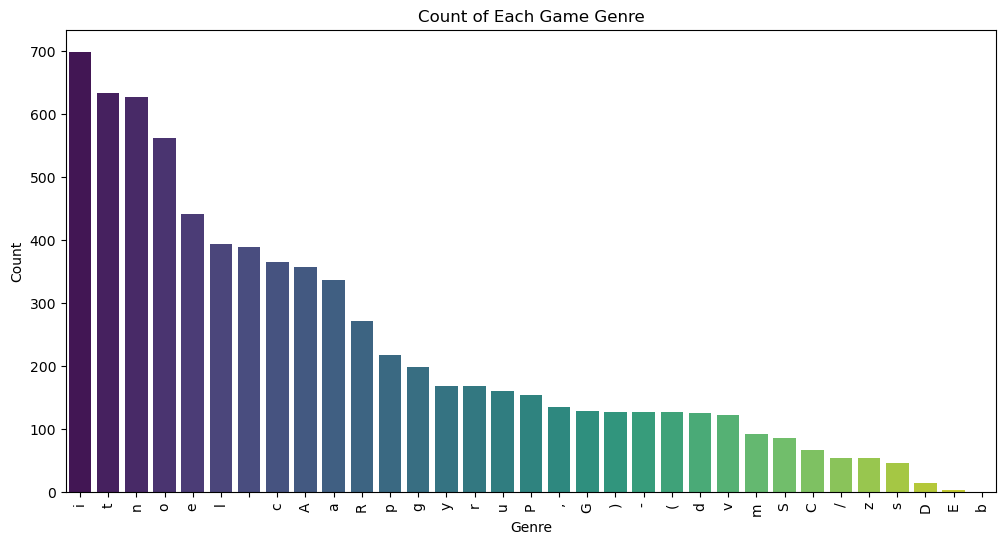

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the 'Genre' lists to count each genre individually
all_genres = [genre for sublist in all_combined_df['Genre'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Count of Each Game Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


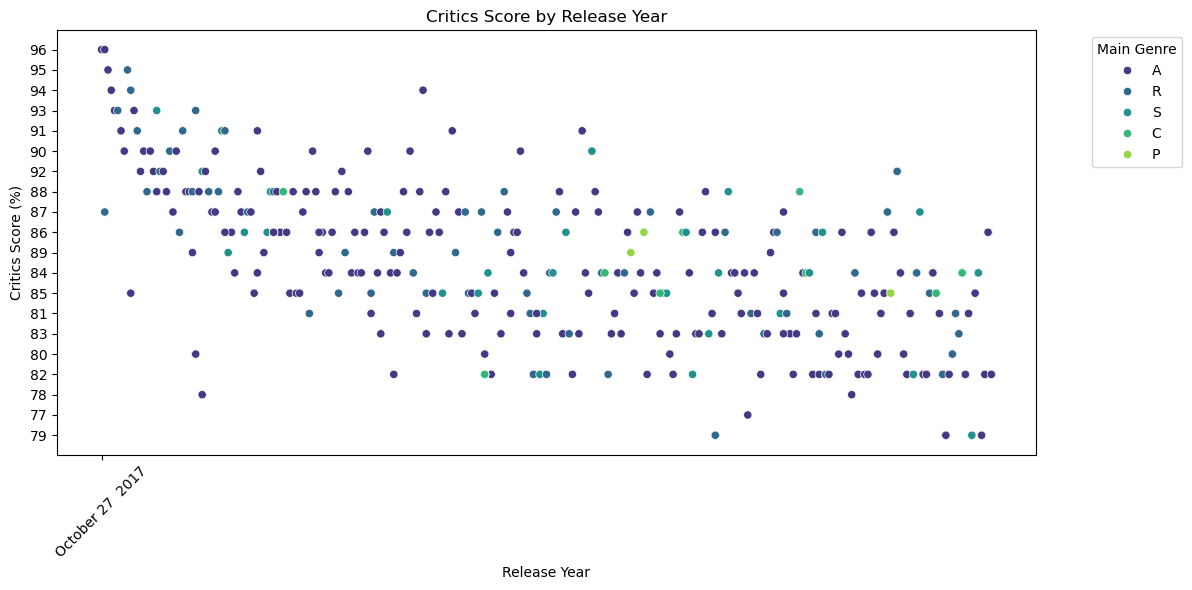

In [188]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
sns.scatterplot(x=all_combined_df['Released'], y=all_combined_df['Critics'], hue=all_combined_df['Genre'].apply(lambda x: x[0]), palette="viridis")

# Rotate x-axis labels and set the interval to avoid overlapping
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Set major ticks every 5 years

# Additional plot settings
plt.title('Critics Score by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Critics Score (%)')
plt.legend(title="Main Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjusts layout to fit rotated labels
plt.show()
